<a href="https://colab.research.google.com/github/opsifiz/AIB5_Mental-Health-Sentiment-Analysis/blob/main/baseline/baseline_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Data Set

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!gdown https://drive.google.com/uc?id=1aH8KYfnN3l16dLpPpMJgJh3Q0OiaEufo

Downloading...
From: https://drive.google.com/uc?id=1aH8KYfnN3l16dLpPpMJgJh3Q0OiaEufo
To: /content/train_dataset.csv
100% 87.2M/87.2M [00:02<00:00, 29.7MB/s]


In [ ]:
df = pd.read_csv('train_dataset.csv',index_col=False)
df

,text,status,from,translated
0,oh my gosh,Anxiety,df1,โอ้พระเจ้า!
1,trouble sleeping confused mind restless heart ...,Anxiety,df1,นอนไม่หลับ วุ่นวายใจ กระวนกระวายใจ ทุกอย่างดูผ...
2,all wrong back off dear forward doubt stay in ...,Anxiety,df1,ทุกอย่างไม่ถูกต้อง ถอยไปเถอะ อย่าก้าวไปข้างหน้...
3,i have shifted my focus to something else but ...,Anxiety,df1,ฉันพยายามเบนความสนใจไปเรื่องอื่นแล้ว แต่ก็ยังก...
4,i am restless and restless it is been a month ...,Anxiety,df1,ฉันกระวนกระวายใจมาก มันเป็นแบบนี้มาเป็นเดือนแล...
...,...,...,...,...
104995,low testosterone after discontinuing rispredon...,schizophrenia,df3,-
104996,how did you finally accept your diagnosis i am...,schizophrenia,df3,-
104997,constantly feel like i am in a competition wit...,schizophrenia,df3,-
104998,has anyone switched over to an entirely differ...,schizophrenia,df3,-


In [ ]:
#Create Temporay Dataset where each status have 100 texts.
temp = df
temp = temp.groupby('status').head(100)
temp = temp.drop(columns=['from','translated'])
temp

,text,status
0,oh my gosh,Anxiety
1,trouble sleeping confused mind restless heart ...,Anxiety
2,all wrong back off dear forward doubt stay in ...,Anxiety
3,i have shifted my focus to something else but ...,Anxiety
4,i am restless and restless it is been a month ...,Anxiety
...,...,...
39841,hey you all so a few years back i was supposed...,schizophrenia
39920,my friend is too busy dealing with her own men...,schizophrenia
39991,i feel like everything i have gone through in ...,schizophrenia
40007,lately i have had this strange feeling like a ...,schizophrenia


# Baseline #2

In [ ]:
import os
from huggingface_hub import login
login(token = "HUGGING_FACE_TOKEN")

In [ ]:
temp['status'].value_counts().index

Index(['Anxiety', 'Normal', 'depression', 'bipolar', 'BPD', 'schizophrenia',
       'mentalillness'],
      dtype='object', name='status')

In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, pipeline
from datasets import Dataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

# Encode labels
labels = temp['status'].unique().tolist()
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for label, i in label2id.items()}
temp['label'] = temp['status'].map(label2id)

# Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(temp)

# Tokenizer from the mental health BERT model
model_name = "nateraw/bert-base-uncased-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize text
def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding=True)

dataset = dataset.map(tokenize, batched=True)

# Split into train/test sets
dataset = dataset.train_test_split(test_size=0.2)
train_dataset = dataset["train"]
test_dataset = dataset["test"]

# Load the model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

#Training arguments
training_args = TrainingArguments(
    output_dir="./mental-health-model",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy': accuracy_score(predictions, labels)}

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Fine-tune the model
trainer.train()

In [ ]:
# Evaluate
metrics = trainer.evaluate()
trainer.predict(test_dataset).metrics

{'test_loss': 1.0427950620651245,
 'test_accuracy': 0.6357142857142857,
 'test_runtime': 4.1679,
 'test_samples_per_second': 33.59,
 'test_steps_per_second': 2.159}

<Figure size 800x600 with 0 Axes>

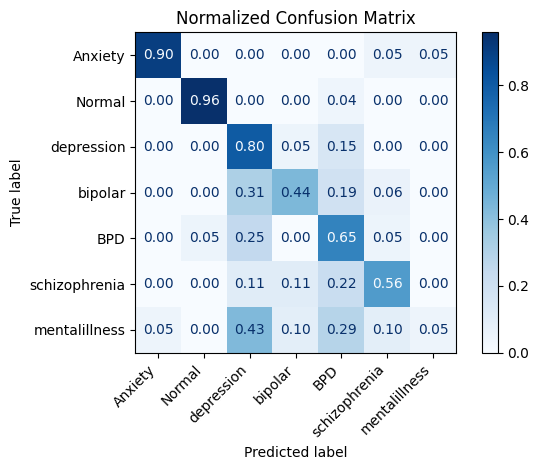

In [ ]:
# Predict on test dataset
predictions_output = trainer.predict(test_dataset)
preds = np.argmax(predictions_output.predictions, axis=1)
true_labels = predictions_output.label_ids

# Get label names in original order (consistent with candidate_labels if available)
# If you already have candidate_labels defined as a list of class names, use it here.
# Otherwise:
candidate_labels = [id2label[i] for i in range(len(id2label))]

# Compute normalized confusion matrix
cm = confusion_matrix(true_labels, preds, labels=range(len(candidate_labels)), normalize='true')

# Display normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=candidate_labels)

plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", values_format=".2f")
plt.xticks(rotation=45, ha='right')
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()